In [1]:
import utilities


{'chemical_features': (0, 1), 'diamino_chemical_features': (1, 2), 'diamino_atoms': (2, 8), 'atoms': (8, 14), 'sequence_metadata': (14, 21), 'one_hot': (21, 41)}


D:\Pycharm_envs\retention_prediction\lib\site-packages\psims\mzmlb\writer.py:33: UserWarning: hdf5plugin is missing! Only the slower GZIP compression scheme will be available! Please install hdf5plugin to be able to use Blosc.
  warnings.warn(


In [4]:
peptide = "A"
utilities.aa_chemical_feature()

{'V': array([0.7693063], dtype=float32),
 'Y': array([1.1566602], dtype=float32),
 'W': array([2.1846123], dtype=float32),
 'T': array([-0.9205796], dtype=float32),
 'S': array([-1.435417], dtype=float32),
 'P': array([0.4627892], dtype=float32),
 'F': array([1.546797], dtype=float32),
 'M': array([0.89798254], dtype=float32),
 'K': array([0.07092968], dtype=float32),
 'L': array([1.2862641], dtype=float32),
 'I': array([1.2862641], dtype=float32),
 'H': array([-0.14534178], dtype=float32),
 'G': array([-0.5884863], dtype=float32),
 'Q': array([-1.0733744], dtype=float32),
 'E': array([-0.27918628], dtype=float32),
 'C': array([-0.19304873], dtype=float32),
 'D': array([-0.796144], dtype=float32),
 'N': array([-1.5903322], dtype=float32),
 'R': array([-1.0763296], dtype=float32),
 'A': array([-0.07364886], dtype=float32)}

In [7]:
from typing import List, Tuple, Dict
import torch
from torch.utils.data import Dataset
import utilities as u
class SkipGramDataset(Dataset):
    def __init__(self,
                 peptides: List[str],
                 aa_to_idx: Dict[str,int],
                 window_size: int = 2):
        self.pairs: List[Tuple[int,int]] = []
        for pep in peptides:
            _, _, seq, _ = u.peptide_parser(pep)
            indices = [aa_to_idx[aa] for aa in seq]
            for i, center in enumerate(indices):
                start = max(0, i - window_size)
                end   = min(len(indices), i + window_size + 1)
                for j in range(start, end):
                    if i == j: continue
                    self.pairs.append((center, indices[j]))
        # optional: subsample high-freq pairs here
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        return torch.tensor(self.pairs[idx][0], dtype=torch.long), \
               torch.tensor(self.pairs[idx][1], dtype=torch.long)


In [8]:
import torch.nn as nn

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.out       = nn.Linear(emb_dim, vocab_size, bias=False)
    def forward(self, center_idxs):
        emb = self.embedding(center_idxs)      # (batch, emb_dim)
        logits = self.out(emb)                 # (batch, vocab_size)
        return logits


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Hyperparameters
EMB_DIM      = 16
WINDOW_SIZE  = 2
BATCH_SIZE   = 512
EPOCHS       = 10
LEARNING_RATE= 1e-2
amino_acids_order= Dict[str, int] = {aa: i for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}
# Prepare dataset & loader
dataset = SkipGramDataset(peptides=your_peptide_list,
                          aa_to_idx=amino_acids_order,
                          window_size=WINDOW_SIZE)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model + optimizer + loss
model = SkipGramModel(vocab_size=len(config.amino_acids_order),
                      emb_dim=EMB_DIM)
opt   = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

# Train
model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    for center, context in loader:
        opt.zero_grad()
        logits = model(center)           # (B, V)
        loss   = loss_fn(logits, context)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    avg = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{EPOCHS} — avg loss: {avg:.4f}")


In [12]:
mods= u.mod_chemical_features()

In [13]:
aas= u.aa_chemical_feature()

In [14]:
def build_plogp_map(base_plogp, mod_plogp):
    # 1. Base residues → scalar
    base_map = { aa: float(val[0]) for aa, val in base_plogp.items() }

    # 2. Modified residues → scalar, with key "X[ModName]"
    mod_map  = {}
    for mod_name, aa_dict in mod_plogp.items():
        for aa, props in aa_dict.items():
            key = f"{aa}[{mod_name}]"
            mod_map[key] = float(props['MolLogP_rdkit'])

    # 3. Combine (mod_map overrides base_map if keys collide)
    return { **base_map, **mod_map }

# Usage:
plogp_map = build_plogp_map(aas, mods)

In [15]:
plogp_map

{'V': 0.7693063020706177,
 'Y': 1.1566601991653442,
 'W': 2.184612274169922,
 'T': -0.9205796122550964,
 'S': -1.4354170560836792,
 'P': 0.4627892076969147,
 'F': 1.5467970371246338,
 'M': 0.8979825377464294,
 'K': 0.07092968374490738,
 'L': 1.2862640619277954,
 'I': 1.2862640619277954,
 'H': -0.14534178376197815,
 'G': -0.5884863138198853,
 'Q': -1.0733743906021118,
 'E': -0.27918627858161926,
 'C': -0.19304873049259186,
 'D': -0.7961440086364746,
 'N': -1.5903321504592896,
 'R': -1.0763295888900757,
 'A': -0.0736488550901413,
 'K[Propionyl]': 0.8229766389241188,
 'M[Oxidation]': -0.4066698235364236,
 'P[Oxidation]': -0.9010992826850708,
 'C[Carbamidomethyl]': -1.135658420367488,
 'K[Carbamidomethyl]': -1.100275770784884,
 'C[Methyl]': 0.3810248173586569,
 'E[Methyl]': -0.1620392200552131,
 'N[Methyl]': -1.2448543127122975,
 'K[Methyl]': 0.4164074669412592,
 'R[Methyl]': -0.7308517548994186,
 'N[Dimethyl]': -0.7913733131929548,
 'K[Dimethyl]': 0.869888466460602,
 'R[Dimethyl]': -0.277

# 2.1 Skip gram for aa and mods

In [28]:
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import tqdm

# --- 1. Build the flattened MolLogP map ------------------------------

def build_plogp_map(
    base_plogp: Dict[str, np.ndarray],
    mod_plogp: Dict[str, Dict[str, Dict[str, float]]]
) -> Dict[str, float]:
    """
    Merge base-residue and modification-residue MolLogP into one dict.
    Keys:
      - 'A', 'C', … for unmodified residues
      - 'K[Propionyl]', 'M[Oxidation]', … for modified residues
    """
    # a) base residues
    base_map = { aa: float(vals[0])
                 for aa, vals in base_plogp.items() }

    # b) modified residues
    mod_map: Dict[str,float] = {}
    for mod_name, aa_dict in mod_plogp.items():
        for aa, props in aa_dict.items():
            key = f"{aa}[{mod_name}]"
            mod_map[key] = float(props['MolLogP_rdkit'])

    # c) merge (mods override if same key ever occurs)
    return { **base_map, **mod_map }


# 2.1 Build the full token ↔ index mapping
plogp_map    = build_plogp_map(aas, mods)
token_list   = sorted(plogp_map.keys())
token_to_idx = { token: idx for idx, token in enumerate(token_list) }

# 2.2 Peptide → list of tokens (plain or modified)
def tokenize_peptide(peptide: str) -> List[str]:
    """
    Parses a ProForma string into tokens like ['A','C','M[Oxidation]',…].
    """
    parsed, modifiers, sequence, _ = u.peptide_parser(peptide)
    tokens: List[str] = []
    for aa, mods in parsed:
        if mods:
            tokens.append(f"{aa}[{mods[0].name}]")
        else:
            tokens.append(aa)
    return tokens

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class SkipGramDataset(Dataset):
    def __init__(self,
                 peptides: List[str],
                 token_to_idx: Dict[str,int],
                 window: int = 2):
        self.pairs: List[Tuple[int,int]] = []
        for pep in peptides:
            toks = tokenize_peptide(pep)
            idxs = [ token_to_idx[t] for t in toks ]
            for i, center in enumerate(idxs):
                for j in range(max(0, i-window),
                               min(len(idxs), i+window+1)):
                    if i==j: continue
                    self.pairs.append((center, idxs[j]))

    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        c, ctx = self.pairs[i]
        return torch.tensor(c, dtype=torch.long), torch.tensor(ctx, dtype=torch.long)


class SkipGramModel(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.out = nn.Linear(emb_dim, vocab_size, bias=False)

    def forward(self, centers: torch.LongTensor):
        h      = self.emb(centers)     # (B, emb_dim)
        logits = self.out(h)           # (B, vocab_size)
        return logits



In [26]:
df = pd.read_csv("../../Data_files/proteometools_library.csv", keep_default_na=False)
peptide_list = []
errors = []
for idx, row in df.iterrows():
    seq = row["seq"]
    mod = row["modifications"]
    try:
        proform = u.reform_seq(seq, mod)
        peptide_list.append(proform)
    except Exception as e:
        errors.append((idx, seq, mod, str(e)))
        print(f"Error at index {idx}: {e}")
print(f"Parsed {len(peptide_list)} peptides with {len(errors)} errors.")

Parsed 156120 peptides with 0 errors.


In [29]:

# Hyperparameters
EMB_DIM     = 16
WINDOW      = 2
BATCH_SIZE  = 512
EPOCHS      = 5
LR          = 1e-2

# Prepare data & model
dataset = SkipGramDataset(
    peptides     = peptide_list,
    token_to_idx = token_to_idx,
    window       = WINDOW
)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model   = SkipGramModel(vocab_size=len(token_list), emb_dim=EMB_DIM)
optim   = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    for centers, contexts in loader:
        optim.zero_grad()
        logits = model(centers)
        loss   = loss_fn(logits, contexts)
        loss.backward()
        optim.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} — loss: {total_loss/len(loader):.4f}")

# Extract embedding matrix for downstream use
emb_matrix = model.emb.weight.detach().cpu()  # shape (V, EMB_DIM)

Epoch 1/5 — loss: 2.8952
Epoch 2/5 — loss: 2.8907
Epoch 3/5 — loss: 2.8907
Epoch 4/5 — loss: 2.8906
Epoch 5/5 — loss: 2.8906


# 2.2 improved skip gram for AA and mods

In [30]:
class MolLogPRegressor(nn.Module):
    def __init__(self,
                 embedding_weights: torch.Tensor,
                 freeze_emb: bool = True):
        super().__init__()
        # 5.1 Initialize from pre‐trained Skip-Gram
        self.emb = nn.Embedding.from_pretrained(
            embeddings = embedding_weights,
            freeze     = freeze_emb
        )
        # 5.2 Single‐layer regressor
        self.fc  = nn.Linear(embedding_weights.size(1), 1)

    def forward(self, token_ids: torch.LongTensor):
        e = self.emb(token_ids)   # (B, emb_dim)
        return self.fc(e).squeeze(-1)  # (B,)


In [37]:
from collections import Counter
import random
import math

def compute_subsampling_probs(peptides, tokenize, tau=1e-5):
    # 1) count tokens
    counts = Counter(tok for pep in peptides for tok in tokenize(pep))
    total = sum(counts.values())
    freqs = {tok: cnt/total for tok, cnt in counts.items()}
    # 2) compute discard probabilities
    subsample_p = {
        tok: max(0.0, 1.0 - math.sqrt(tau / freq))
        for tok, freq in freqs.items()
    }
    return subsample_p

import torch
from torch.utils.data import Dataset

class NegSamplingSkipGramDataset(Dataset):
    def __init__(self,
                 peptides: List[str],
                 token_to_idx: Dict[str,int],
                 subsample_p: Dict[str,float],
                 window_max: int = 4,
                 neg_k: int = 5):
        self.token_to_idx = token_to_idx
        self.window_max    = window_max
        self.neg_k         = neg_k
        self.subsample_p   = subsample_p
        self.pairs         = []
        self.vocab         = list(token_to_idx.keys())
        self.vocab_idx     = list(token_to_idx.values())

        # Precompute unigram distribution ^0.75 for negative sampling
        freq = Counter()
        for pep in peptides:
            freq.update(tokenize_peptide(pep))
        total_count = sum(freq.values())
        unigrams = [ (freq[tok]/total_count)**0.75 for tok in self.vocab ]
        Z = sum(unigrams)
        self.neg_dist = [u/Z for u in unigrams]  # normalized

        # Build positive pairs with subsampling & dynamic window
        for pep in peptides:
            toks = tokenize_peptide(pep)
            idxs = [token_to_idx[t] for t in toks
                    if random.random() > subsample_p.get(t,0.0)]
            L = len(idxs)
            for i, center in enumerate(idxs):
                w = random.randint(1, self.window_max)
                for j in range(max(0, i-w), min(L, i+w+1)):
                    if i==j: continue
                    context = idxs[j]
                    self.pairs.append((center, context))

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        # sample negative examples
        negs = torch.multinomial(
            torch.tensor(self.neg_dist),
            self.neg_k,
            replacement=True
        ).tolist()
        return (
            torch.tensor(center, dtype=torch.long),
            torch.tensor(context, dtype=torch.long),
            torch.tensor(negs,    dtype=torch.long)
        )

import torch.nn as nn

class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int):
        super().__init__()
        self.in_emb  = nn.Embedding(vocab_size, emb_dim)
        self.out_emb = nn.Embedding(vocab_size, emb_dim)

    def forward(self, centers, contexts, negatives):
        # centers: (B,)
        # contexts: (B,)
        # negatives: (B, K)
        v_c = self.in_emb(centers)       # (B, D)
        v_o = self.out_emb(contexts)     # (B, D)
        v_n = self.out_emb(negatives)    # (B, K, D)

        # positive score: sigmoid(v_c · v_o)
        pos_score = torch.sum(v_c * v_o, dim=1)             # (B,)
        # negative scores: sigmoid(-v_c · v_n)
        neg_score = torch.bmm(v_n, v_c.unsqueeze(2)).squeeze(2)  # (B, K)

        return pos_score, neg_score

from torch.utils.data import DataLoader

# Hyperparameters
EMB_DIM     = 32
WINDOW_MAX  = 4
NEG_K       = 10
BATCH_SIZE  = 1024
EPOCHS      = 50
LR          = 5e-3
TAU         = 1e-5  # subsampling threshold

# 1) compute subsampling
sub_p = compute_subsampling_probs(peptide_list,
                                  tokenize_peptide,
                                  tau=TAU)

# 2) prepare dataset & loader
ds = NegSamplingSkipGramDataset(
    peptides      = peptide_list,
    token_to_idx  = token_to_idx,
    subsample_p   = sub_p,
    window_max    = WINDOW_MAX,
    neg_k         = NEG_K
)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

# 3) instantiate model, loss, optimizer, scheduler
model = SkipGramNegSampling(vocab_size=len(token_list), emb_dim=EMB_DIM)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
# binary cross-entropy with logits
bce   = nn.BCEWithLogitsLoss(reduction='mean')
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

# 4) train
model.train()
for epoch in range(1, EPOCHS+1):
    total_loss = 0.0
    for centers, contexts, negatives in loader:
        opt.zero_grad()
        pos_score, neg_score = model(centers, contexts, negatives)
        # labels: positive=1, negatives=0
        pos_loss = bce(pos_score, torch.ones_like(pos_score))
        neg_loss = bce(neg_score, torch.zeros_like(neg_score))
        loss     = pos_loss + neg_loss.mean()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    sched.step()
    avg = total_loss / len(loader)
    print(f"Epoch {epoch:2d}/{EPOCHS} — loss: {avg:.4f} — lr: {sched.get_last_lr()[0]:.4e}")
final_embeddings = model.in_emb.weight.data
final_embeddings.shape


Epoch  1/50 — loss: 4.5693 — lr: 5.0000e-03
Epoch  2/50 — loss: 4.2929 — lr: 5.0000e-03
Epoch  3/50 — loss: 3.9357 — lr: 5.0000e-03
Epoch  4/50 — loss: 3.7166 — lr: 5.0000e-03
Epoch  5/50 — loss: 3.5263 — lr: 5.0000e-03
Epoch  6/50 — loss: 3.2405 — lr: 5.0000e-03
Epoch  7/50 — loss: 3.0537 — lr: 5.0000e-03
Epoch  8/50 — loss: 2.9111 — lr: 5.0000e-03
Epoch  9/50 — loss: 2.7111 — lr: 5.0000e-03
Epoch 10/50 — loss: 2.5632 — lr: 2.5000e-03
Epoch 11/50 — loss: 2.4058 — lr: 2.5000e-03
Epoch 12/50 — loss: 2.3673 — lr: 2.5000e-03
Epoch 13/50 — loss: 2.3192 — lr: 2.5000e-03
Epoch 14/50 — loss: 2.2436 — lr: 2.5000e-03
Epoch 15/50 — loss: 2.1919 — lr: 2.5000e-03
Epoch 16/50 — loss: 2.1538 — lr: 2.5000e-03
Epoch 17/50 — loss: 2.0921 — lr: 2.5000e-03
Epoch 18/50 — loss: 2.0315 — lr: 2.5000e-03
Epoch 19/50 — loss: 2.0240 — lr: 2.5000e-03
Epoch 20/50 — loss: 1.9626 — lr: 1.2500e-03
Epoch 21/50 — loss: 1.9138 — lr: 1.2500e-03
Epoch 22/50 — loss: 1.9107 — lr: 1.2500e-03
Epoch 23/50 — loss: 1.8832 — lr:

# 3.1 mollog p regression

In [33]:
from torch.utils.data import Dataset, DataLoader

class TokenRegDataset(Dataset):
    def __init__(self,
                 plogp_map: Dict[str,float],
                 token_to_idx: Dict[str,int]):
        self.items = [
            (token_to_idx[tok], plogp_map[tok])
            for tok in plogp_map
        ]

    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        tid, val = self.items[i]
        return torch.tensor(tid, dtype=torch.long), \
               torch.tensor(val, dtype=torch.float32)

# Prepare regression data
reg_ds = TokenRegDataset(plogp_map, token_to_idx)
reg_loader = DataLoader(reg_ds, batch_size=16, shuffle=True)

# Instantiate regressor (freeze or fine‐tune embedding as you prefer)
reg_model = MolLogPRegressor(
    embedding_weights = emb_matrix,
    freeze_emb        = True
)
reg_optim = torch.optim.Adam(reg_model.parameters(), lr=1e-3)
reg_loss  = nn.MSELoss()

# Train
reg_model.train()
for epoch in range(100):
    epoch_loss = 0.0
    for token_ids, labels in reg_loader:
        reg_optim.zero_grad()
        preds = reg_model(token_ids)
        loss  = reg_loss(preds, labels)
        loss.backward()
        reg_optim.step()
        epoch_loss += loss.item()
    if (epoch+1)%10==0:
        print(f"Epoch {epoch+1:3d} — MSE: {epoch_loss/len(reg_loader):.4f}")

Epoch  10 — MSE: 1.2339
Epoch  20 — MSE: 1.0857
Epoch  30 — MSE: 1.2373
Epoch  40 — MSE: 0.9331
Epoch  50 — MSE: 1.0549
Epoch  60 — MSE: 0.8477
Epoch  70 — MSE: 0.7943
Epoch  80 — MSE: 0.7176
Epoch  90 — MSE: 0.7042
Epoch 100 — MSE: 0.6978


# 1.3 Tokenize plain sequence no mods

In [41]:
def tokenize_plain(peptide: str) -> List[str]:
    """
    Parse ProForma → raw sequence, ignore any modifications.
    """
    parsed, modifiers, sequence, _ = u.peptide_parser(peptide)
    return list(sequence)


def compute_subsampling_probs(
    peptides: List[str],
    tokenize_fn,
    tau: float = 1e-5
) -> Dict[str, float]:
    """
    For each AA token t, compute
      P_discard(t) = 1 − sqrt(tau / f(t))
    where f(t) = freq(t) in corpus.
    """
    counts = Counter(tok for pep in peptides for tok in tokenize_fn(pep))
    total  = sum(counts.values())
    freqs  = {t: c/total for t,c in counts.items()}
    return { t: max(0.0, 1.0 - math.sqrt(tau / freq))
             for t, freq in freqs.items() }

class AAOnlySkipGramDataset(Dataset):
    def __init__(self,
                 peptides: List[str],
                 aa_to_idx: Dict[str,int],
                 window: int = 2):
        self.pairs = []
        for pep in peptides:
            idxs = [aa_to_idx[aa] for aa in tokenize_plain(pep)]
            for i, center in enumerate(idxs):
                for j in range(max(0, i-window), min(len(idxs), i+window+1)):
                    if i == j: continue
                    self.pairs.append((center, idxs[j]))
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        c, ctx = self.pairs[i]
        return torch.tensor(c), torch.tensor(ctx)



# 2.3 Skipgram for AA only

In [359]:
from typing import List, Tuple, Dict
class AASkipGramNegDataset(Dataset):
    def __init__(self,
                 peptides: List[str],
                 aa_to_idx: Dict[str,int],
                 subsample_p: Dict[str,float],
                 window_max: int = 4,
                 neg_k: int = 5):
        self.aa_to_idx   = aa_to_idx
        self.window_max  = window_max
        self.neg_k       = neg_k

        # Prepare unigram^0.75 distribution for negatives
        token_list = list(aa_to_idx.keys())
        raw_counts = Counter(tok for pep in peptides for tok in tokenize_plain(pep))
        total = sum(raw_counts.values())
        # build list of probs in same order as token_list
        unigrams = [(raw_counts[t]/total)**0.75 for t in token_list]
        Z = sum(unigrams)
        self.neg_dist = [u/Z for u in unigrams]

        # Build positive (center,context) pairs with subsampling & dynamic windows
        self.pairs: List[tuple] = []
        for pep in peptides:
            toks = [t for t in tokenize_plain(pep)
                    if random.random() > subsample_p.get(t, 0.0)]
            idxs = [aa_to_idx[t] for t in toks]
            L = len(idxs)
            for i, c in enumerate(idxs):
                w = random.randint(1, self.window_max)
                for j in range(max(0, i-w), min(L, i+w+1)):
                    if i == j: continue
                    self.pairs.append((c, idxs[j]))

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        # sample neg_k negatives (with replacement)
        negs = torch.multinomial(
            torch.tensor(self.neg_dist),
            self.neg_k,
            replacement=True
        )
        return (
            torch.tensor(center,  dtype=torch.long),
            torch.tensor(context, dtype=torch.long),
            negs
        )

class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int):
        super().__init__()
        self.in_emb  = nn.Embedding(vocab_size, emb_dim)
        self.out_emb = nn.Embedding(vocab_size, emb_dim)

    def forward(self, centers, contexts, negs):
        # centers: (B,), contexts: (B,), negs: (B, K)
        v_c = self.in_emb(centers)       # (B, D)
        v_o = self.out_emb(contexts)     # (B, D)
        v_n = self.out_emb(negs)         # (B, K, D)

        # positive scores: v_c·v_o, negative: v_c·v_n
        pos = torch.sum(v_c * v_o, dim=1)               # (B,)
        neg = torch.bmm(v_n, v_c.unsqueeze(2)).squeeze(2)  # (B, K)
        return pos, neg



# Hyperparameters
EMB_DIM    = 32
WINDOW_MAX = 4
NEG_K      = 10
BATCH      = 1024
EPOCHS     = 30
LR         = 5e-3
TAU        = 1e-5  # subsampling threshold
amino_acids_order = {aa: i for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}
# 5.1 Prepare data
peptide_list = peptide_list  # list of ProForma strings
sub_p        = compute_subsampling_probs(peptide_list, tokenize_plain, tau=TAU)
dataset      = AASkipGramNegDataset(
    peptides    = peptide_list,
    aa_to_idx   = amino_acids_order,
    subsample_p = sub_p,
    window_max  = WINDOW_MAX,
    neg_k       = NEG_K
)
loader = DataLoader(dataset, batch_size=BATCH, shuffle=True)

# 5.2 Model, loss, optimizer
model = SkipGramNegSampling(vocab_size=20, emb_dim=EMB_DIM)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
bce   = nn.BCEWithLogitsLoss(reduction='mean')
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

# 5.3 Train
model.train()
for epoch in range(1, EPOCHS+1):
    total_loss = 0.0
    for centers, contexts, negs in loader:
        opt.zero_grad()
        pos_score, neg_score = model(centers, contexts, negs)
        # positive labels = 1, negatives = 0
        pos_loss = bce(pos_score, torch.ones_like(pos_score))
        neg_loss = bce(neg_score, torch.zeros_like(neg_score))
        loss     = pos_loss + neg_loss.mean()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    sched.step()
    avg = total_loss / len(loader)
    print(f"Epoch {epoch:2d}/{EPOCHS} — loss: {avg:.4f} — lr: {sched.get_last_lr()[0]:.1e}")

# After training, your amino‐acid embeddings are:
aa_embeddings = model.in_emb.weight.data  # shape (20, EMB_DIM)

Epoch  1/30 — loss: 5.0213 — lr: 5.0e-03
Epoch  2/30 — loss: 4.6903 — lr: 5.0e-03
Epoch  3/30 — loss: 4.3420 — lr: 5.0e-03
Epoch  4/30 — loss: 4.0513 — lr: 5.0e-03
Epoch  5/30 — loss: 3.8236 — lr: 5.0e-03
Epoch  6/30 — loss: 3.5741 — lr: 5.0e-03
Epoch  7/30 — loss: 3.3567 — lr: 5.0e-03
Epoch  8/30 — loss: 3.1588 — lr: 5.0e-03
Epoch  9/30 — loss: 2.9319 — lr: 5.0e-03
Epoch 10/30 — loss: 2.8318 — lr: 2.5e-03
Epoch 11/30 — loss: 2.6765 — lr: 2.5e-03
Epoch 12/30 — loss: 2.6141 — lr: 2.5e-03
Epoch 13/30 — loss: 2.6134 — lr: 2.5e-03
Epoch 14/30 — loss: 2.4737 — lr: 2.5e-03
Epoch 15/30 — loss: 2.4883 — lr: 2.5e-03
Epoch 16/30 — loss: 2.3366 — lr: 2.5e-03
Epoch 17/30 — loss: 2.2961 — lr: 2.5e-03
Epoch 18/30 — loss: 2.2592 — lr: 2.5e-03
Epoch 19/30 — loss: 2.1687 — lr: 2.5e-03
Epoch 20/30 — loss: 2.1521 — lr: 1.3e-03
Epoch 21/30 — loss: 2.1252 — lr: 1.3e-03
Epoch 22/30 — loss: 2.0951 — lr: 1.3e-03
Epoch 23/30 — loss: 2.0784 — lr: 1.3e-03
Epoch 24/30 — loss: 2.0395 — lr: 1.3e-03
Epoch 25/30 — lo

In [179]:
plogp_map

{'V': 0.7693063020706177,
 'Y': 1.1566601991653442,
 'W': 2.184612274169922,
 'T': -0.9205796122550964,
 'S': -1.4354170560836792,
 'P': 0.4627892076969147,
 'F': 1.5467970371246338,
 'M': 0.8979825377464294,
 'K': 0.07092968374490738,
 'L': 1.2862640619277954,
 'I': 1.2862640619277954,
 'H': -0.14534178376197815,
 'G': -0.5884863138198853,
 'Q': -1.0733743906021118,
 'E': -0.27918627858161926,
 'C': -0.19304873049259186,
 'D': -0.7961440086364746,
 'N': -1.5903321504592896,
 'R': -1.0763295888900757,
 'A': -0.0736488550901413,
 'K[Propionyl]': 0.8229766389241188,
 'M[Oxidation]': -0.4066698235364236,
 'P[Oxidation]': -0.9010992826850708,
 'C[Carbamidomethyl]': -1.135658420367488,
 'K[Carbamidomethyl]': -1.100275770784884,
 'C[Methyl]': 0.3810248173586569,
 'E[Methyl]': -0.1620392200552131,
 'N[Methyl]': -1.2448543127122975,
 'K[Methyl]': 0.4164074669412592,
 'R[Methyl]': -0.7308517548994186,
 'N[Dimethyl]': -0.7913733131929548,
 'K[Dimethyl]': 0.869888466460602,
 'R[Dimethyl]': -0.277

In [181]:
import re
def reformat_peptide(peptide: str) -> str:
    """
    Convert ProForma peptide to a format suitable for parsing.
    - Remove "(N-T)" and "(C-T)" suffixes from modifications
    """
    # 1) remove suffixes
    peptide = re.sub(
        r'([A-Z])\[(\w+)\(N-T\)\]',
        r'[\2]-\1',
        peptide
    )
    # C-terminal on the immediately preceding residue
    peptide = re.sub(
        r'([A-Z])\[(\w+)\(C-T\)\]',
        r'\1-[\2]',
        peptide
    )
    return peptide
def atom_counts(peptide: str) -> Dict[str, int]:
    """
    Count atoms in a peptide sequence.
    """
    if peptide == "R[Dimethyl_symmetric]":
        peptide = "R[Dimethyl]"
    peptide = reformat_peptide(peptide)
    parsed, modifiers, sequence, _ = u.peptide_parser(peptide)
    atoms = u.aa_atomic_composition_array()
    encode_seq_mod_atomic = u.encode_sequence_and_modification_atomic(sequence, parsed, atoms, modifiers["n_term"], modifiers["c_term"])

    return list(encode_seq_mod_atomic[8:14,1])




In [264]:
plogp_map_atoms = {}
for k,v in plogp_map.items():
    plogp_map_atoms[k] = (v,atom_counts(k))

# 3.2 mollog p predictor for embedding + atom counts

In [123]:
from torch.utils.data import Dataset, DataLoader
import torch

class MolLogPTokenDataset(Dataset):
    """
    Each item is (aa_idx, atom_counts, mol_logp).
      - aa_idx:    index of the base amino acid in 0…19
      - atom_counts: 6‐dim atomic composition of the *modification* (or zero for unmodified)
      - mol_logp:  target scalar
    """
    def __init__(self,
                 token_data: Dict[str, Tuple[float, List[float]]],
                 aa_to_idx: Dict[str,int]):
        self.items = []
        for token, (mol_logp, atom_counts) in token_data.items():
            # strip off any "[Mod]" to recover the base AA
            aa = token.split('[')[0]
            if aa not in aa_to_idx:
                raise KeyError(f"Unknown amino acid '{aa}' in token '{token}'")
            aa_idx = aa_to_idx[aa]
            self.items.append((
                torch.tensor(aa_idx,       dtype=torch.long),
                torch.tensor(atom_counts,  dtype=torch.float32),
                torch.tensor(mol_logp,     dtype=torch.float32),
            ))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        return self.items[idx]

# Example usage:
dataset = MolLogPTokenDataset(plogp_map_atoms, amino_acids_order)
loader  = DataLoader(dataset, batch_size=32, shuffle=True)

In [124]:
import torch.nn as nn

class MolLogPRegressor(nn.Module):
    """
    Takes:
      - aa_idx     → lookup in pretrained AA embedding
      - atom_counts → concatenated to that embedding
    Outputs:
      - a single scalar MolLogP per token.
    """
    def __init__(self,
                 aa_embedding: torch.Tensor,
                 atom_dim: int = 6,
                 hidden_dim: int = 64,
                 freeze_aa: bool = True):
        super().__init__()
        # 1) load pretrained AA embeddings
        self.aa_emb = nn.Embedding.from_pretrained(
            embeddings = aa_embedding,
            freeze     = freeze_aa
        )
        # 2) simple MLP head
        self.net = nn.Sequential(
            nn.Linear(aa_embedding.size(1) + atom_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, aa_idx, atom_counts):
        e = self.aa_emb(aa_idx)               # (B, D)
        x = torch.cat([e, atom_counts], dim=1)  # (B, D+6)
        return self.net(x).squeeze(-1)          # (B,)


In [150]:
import torch
import torch.optim as optim

# Assume `aa_embedding` is your torch.Tensor from SkipGram: shape (20, D)
model = MolLogPRegressor(
    aa_embedding = aa_embeddings,
    atom_dim     = 6,  # 6
    hidden_dim   = 64,
    freeze_aa    = True
)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()

model.train()
for epoch in range(1, 51):
    total_loss = 0.0
    for aa_idx, atom_counts, label in loader:
        optimizer.zero_grad()
        pred = model(aa_idx, atom_counts)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch:2d}/50 — MSE: {avg_loss:.4f}")


Epoch  1/50 — MSE: 1.5416
Epoch  2/50 — MSE: 1.1342
Epoch  3/50 — MSE: 0.8933
Epoch  4/50 — MSE: 0.8426
Epoch  5/50 — MSE: 0.8151
Epoch  6/50 — MSE: 0.8059
Epoch  7/50 — MSE: 0.7411
Epoch  8/50 — MSE: 0.6770
Epoch  9/50 — MSE: 0.6391
Epoch 10/50 — MSE: 0.5761
Epoch 11/50 — MSE: 0.5393
Epoch 12/50 — MSE: 0.5193
Epoch 13/50 — MSE: 0.4860
Epoch 14/50 — MSE: 0.4539
Epoch 15/50 — MSE: 0.3978
Epoch 16/50 — MSE: 0.4172
Epoch 17/50 — MSE: 0.3567
Epoch 18/50 — MSE: 0.3352
Epoch 19/50 — MSE: 0.3610
Epoch 20/50 — MSE: 0.3009
Epoch 21/50 — MSE: 0.2898
Epoch 22/50 — MSE: 0.2769
Epoch 23/50 — MSE: 0.2943
Epoch 24/50 — MSE: 0.2943
Epoch 25/50 — MSE: 0.2380
Epoch 26/50 — MSE: 0.2616
Epoch 27/50 — MSE: 0.2533
Epoch 28/50 — MSE: 0.2177
Epoch 29/50 — MSE: 0.2210
Epoch 30/50 — MSE: 0.2329
Epoch 31/50 — MSE: 0.2050
Epoch 32/50 — MSE: 0.1938
Epoch 33/50 — MSE: 0.1964
Epoch 34/50 — MSE: 0.1898
Epoch 35/50 — MSE: 0.2007
Epoch 36/50 — MSE: 0.1907
Epoch 37/50 — MSE: 0.2113
Epoch 38/50 — MSE: 0.1745
Epoch 39/50 

In [139]:
import numpy as np

def predict_peptide_logp(peptide_str,
                         model,
                         token_data,
                         aa_to_idx,
                         device='cpu'):
    """
    Returns per-residue and total MolLogP for a peptide.
    """
    model.eval()
    tokens = tokenize_peptide(peptide_str)
    inputs = []
    for tok in tokens:
        if tok not in token_data:
            raise KeyError(f"Unknown token: {tok}")
        aa = tok.split('[')[0]
        idx = aa_to_idx[aa]
        atom_counts = token_data[tok][1]
        inputs.append((idx, atom_counts))

    # build tensors
    aa_idxs      = torch.tensor([i for i,_ in inputs], dtype=torch.long, device=device)
    atom_counts  = torch.tensor([a for _,a in inputs], dtype=torch.float32, device=device)

    with torch.no_grad():
        mol_preds = model(aa_idxs, atom_counts)  # (L,)

    total_logp = mol_preds.sum().item()
    return mol_preds.cpu().numpy(), total_logp

In [144]:

peptide = "R"
per_res, total = predict_peptide_logp(peptide,
                                      model,
                                      plogp_map_atoms,
                                      amino_acids_order)
print("Per-residue MolLogP:", per_res)
print("Peptide MolLogP total:", total)

Per-residue MolLogP: [-1.0204217]
Peptide MolLogP total: -1.0204217433929443


# MLP with cv

In [314]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# 1. Prepare the feature matrix X and target vector y
tokens = list(plogp_map_atoms.keys())
X = np.vstack([plogp_map_atoms[tok][1] for tok in tokens])  # shape: (n_tokens, n_features)
y = np.array([plogp_map_atoms[tok][0] for tok in tokens], dtype=float)

# 2. Convert data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 3. Define a simple MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Regression output
        )

    def forward(self, x):
        return self.model(x).squeeze()  # Squeeze to make output 1D

# 4. Set up 5-fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores, r2_scores = [], []

# 5. Training parameters
epochs = 1000
batch_size = 32
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 6. Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = MLP(input_dim=X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    model.train()
    for epoch in range(epochs):
        idx = torch.randperm(X_train.size(0))
        X_train, y_train = X_train[idx], y_train[idx]

        for i in range(0, X_train.size(0), batch_size):
            x_batch = X_train[i:i+batch_size].to(device)
            y_batch = y_train[i:i+batch_size].to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test.to(device)).cpu().numpy()
        y_true_test = y_test.numpy()

        mse = mean_squared_error(y_true_test, y_pred_test)
        r2 = r2_score(y_true_test, y_pred_test)

    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"Fold {fold}: MSE = {mse:.4f},  R² = {r2:.4f}")

# 7. Aggregate results across folds
print(f"\n=== Final Cross-Validation Results ===")
print(f"Avg MSE over folds: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
print(f"Avg R²  over folds: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1: MSE = 0.2158,  R² = 0.7328
Fold 2: MSE = 0.0624,  R² = 0.9396
Fold 3: MSE = 0.1030,  R² = 0.8606
Fold 4: MSE = 0.1111,  R² = 0.8545
Fold 5: MSE = 0.1263,  R² = 0.9134

=== Final Cross-Validation Results ===
Avg MSE over folds: 0.1237 ± 0.0507
Avg R²  over folds: 0.8602 ± 0.0713


# MLP

In [332]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Prepare the feature matrix X and target vector y
tokens = list(plogp_map_atoms.keys())
X = np.vstack([plogp_map_atoms[tok][1] for tok in tokens])  # shape: (n_tokens, n_features)
y = np.array([plogp_map_atoms[tok][0] for tok in tokens], dtype=float)

# 2. Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

# 3. Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

# 4. Define a deeper MLP model with more layers and Dropout
class DeeperMLP(nn.Module):
    def __init__(self, input_dim):
        super(DeeperMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  # First hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Dropout with 30% probability

            nn.Linear(128, 64),  # Second hidden layer with 64 neurons
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Dropout again

            nn.Linear(64, 32),  # Third hidden layer with 32 neurons
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(32, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.model(x).squeeze()  # Squeeze to make output 1D

# 5. Training parameters
epochs = 200
batch_size = 64
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 6. Initialize the model, optimizer, and loss function
model = DeeperMLP(input_dim=X_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # L2 regularization
criterion = nn.MSELoss()

# 7. Training loop
model.train()
for epoch in range(epochs):
    # Shuffle the training data
    idx = torch.randperm(X_train.size(0))
    X_train, y_train = X_train[idx], y_train[idx]

    # Mini-batch training
    for i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# 8. Evaluation on the validation
model.eval()
with torch.no_grad():
    y_pred_valid = model(X_valid.to(device)).cpu().numpy()
    mse = mean_squared_error(y_valid.numpy(), y_pred_valid)
    r2 = r2_score(y_valid.numpy(), y_pred_valid)

# 9. Print results
print(f"\nValidation MSE: {mse:.4f}")
print(f"Validation R²: {r2:.4f}")

Epoch 10/200, Loss: 0.9810
Epoch 20/200, Loss: 1.0535
Epoch 30/200, Loss: 0.2540
Epoch 40/200, Loss: 0.2883
Epoch 50/200, Loss: 0.5541
Epoch 60/200, Loss: 0.2489
Epoch 70/200, Loss: 0.6007
Epoch 80/200, Loss: 0.3069
Epoch 90/200, Loss: 0.1518
Epoch 100/200, Loss: 0.1975
Epoch 110/200, Loss: 0.2495
Epoch 120/200, Loss: 0.1097
Epoch 130/200, Loss: 0.1814
Epoch 140/200, Loss: 0.3028
Epoch 150/200, Loss: 0.2323
Epoch 160/200, Loss: 0.2136
Epoch 170/200, Loss: 0.5437
Epoch 180/200, Loss: 0.2528
Epoch 190/200, Loss: 0.1117
Epoch 200/200, Loss: 0.2949

Validation MSE: 0.1312
Validation R²: 0.8720


Epoch 10/2000, Train Loss: 1.1557, Validation Loss: 0.8701
Epoch 20/2000, Train Loss: 0.7527, Validation Loss: 0.2669
Epoch 30/2000, Train Loss: 0.6110, Validation Loss: 0.1652
Epoch 40/2000, Train Loss: 0.4687, Validation Loss: 0.1385
Epoch 50/2000, Train Loss: 0.4235, Validation Loss: 0.1345
Epoch 60/2000, Train Loss: 0.3352, Validation Loss: 0.1344
Epoch 70/2000, Train Loss: 0.3295, Validation Loss: 0.1679
Epoch 80/2000, Train Loss: 0.3386, Validation Loss: 0.1304
Epoch 90/2000, Train Loss: 0.2587, Validation Loss: 0.1299
Epoch 100/2000, Train Loss: 0.2988, Validation Loss: 0.1451
Epoch 110/2000, Train Loss: 0.3089, Validation Loss: 0.1249
Epoch 120/2000, Train Loss: 0.2472, Validation Loss: 0.1327
Epoch 130/2000, Train Loss: 0.2248, Validation Loss: 0.1345
Epoch 140/2000, Train Loss: 0.2499, Validation Loss: 0.1604
Epoch 150/2000, Train Loss: 0.2279, Validation Loss: 0.1906
Epoch 160/2000, Train Loss: 0.2181, Validation Loss: 0.1386
Epoch 170/2000, Train Loss: 0.2460, Validation Lo

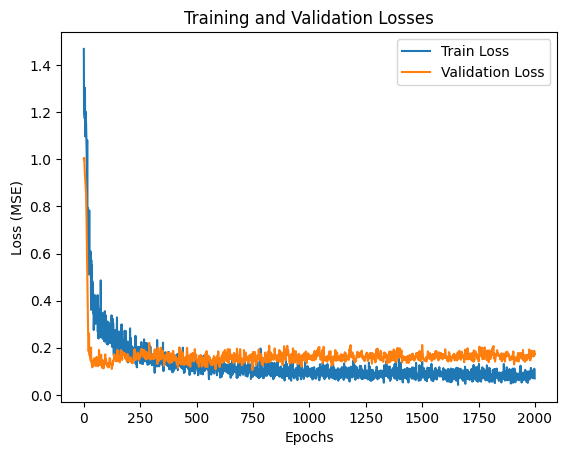

In [412]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Prepare the feature matrix X and target vector y
tokens = list(plogp_map_atoms.keys())
X = np.vstack([plogp_map_atoms[tok][1] for tok in tokens])  # shape: (n_tokens, n_features)
y = np.array([plogp_map_atoms[tok][0] for tok in tokens], dtype=float)

# 2. Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

# 3. Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

# 4. Define a deeper MLP model with more layers and Dropout
class DeeperMLP(nn.Module):
    def __init__(self, input_dim):
        super(DeeperMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  # First hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Dropout with 30% probability

            nn.Linear(128, 64),  # Second hidden layer with 64 neurons
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Dropout again

            nn.Linear(64, 32),  # Third hidden layer with 32 neurons
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(32, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.model(x).squeeze()  # Squeeze to make output 1D

# 5. Training parameters
epochs = 2000
batch_size = 16
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 6. Initialize the model, optimizer, and loss function
model = DeeperMLP(input_dim=X_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # L2 regularization (weight decay)
criterion = nn.MSELoss()

# 7. Training loop with validation loss tracking
train_losses, valid_losses = [], []

for epoch in range(epochs):
    # Shuffle the training data
    idx = torch.randperm(X_train.size(0))
    X_train, y_train = X_train[idx], y_train[idx]

    # Mini-batch training
    model.train()
    train_loss = 0.0
    for i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Compute training loss for the epoch
    train_loss /= (len(X_train) // batch_size)
    train_losses.append(train_loss)

    # Evaluate validation loss
    model.eval()
    with torch.no_grad():
        y_pred_valid = model(X_valid.to(device)).cpu().numpy()
        valid_loss = mean_squared_error(y_valid.numpy(), y_pred_valid)
        valid_losses.append(valid_loss)

    # Print losses for this epoch
    if (epoch+1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

# 8. Final evaluation on validation set
model.eval()
with torch.no_grad():
    y_pred_valid = model(X_valid.to(device)).cpu().numpy()
    mse = mean_squared_error(y_valid.numpy(), y_pred_valid)
    r2 = r2_score(y_valid.numpy(), y_pred_valid)

print(f"\nFinal Validation MSE: {mse:.4f}")
print(f"Final Validation R²: {r2:.4f}")

# 9. Plot the training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()


# MLP with one hot encoder for AA

In [436]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# 1. Define the list of amino acids and initialize one-hot encoder
amino_acids = ['K', 'C', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'Y', 'W']
encoder = OneHotEncoder(sparse=False)
amino_acid_array = np.array(amino_acids).reshape(-1, 1)
one_hot_encoder = encoder.fit(amino_acid_array)

# 2. Define the function to encode amino acid and features
def encode_amino_acid_and_features(key, value, one_hot_encoder):
    """
    Encodes the amino acid part using one-hot encoding and keeps the modification data as is.

    Parameters:
    - key: The amino acid (e.g., 'V')
    - value: A tuple (pLogP_value, modification_features) from plogp_map_atoms
    - one_hot_encoder: The trained OneHotEncoder for amino acids

    Returns:
    - Combined feature vector consisting of one-hot encoded amino acid and modification features
    """
    # Extract the amino acid (key)
    amino_acid = key  # Amino acid is directly in the key (e.g., 'V')

    # Extract the modification features (value[1] is the modification data)
    modification_features = np.array(value[1])  # The list of modification features

    # One-hot encode the amino acid
    amino_acid_one_hot = one_hot_encoder.transform([[amino_acid]])  # Get the one-hot encoded vector

    # Combine the one-hot encoded amino acid and the modification features
    combined_features = np.concatenate((amino_acid_one_hot.flatten(), modification_features))

    return combined_features

# 3. Prepare the feature matrix X and target vector y from plogp_map_atoms
tokens = list(plogp_map_atoms.keys())  # List of keys (e.g., 'F[Acetyl(N-T)]')
X = np.vstack([encode_amino_acid_and_features(tok[0], plogp_map_atoms[tok], one_hot_encoder) for tok in tokens])  # shape: (n_tokens, n_features)
y = np.array([plogp_map_atoms[tok][0] for tok in tokens], dtype=float)  # Extract pLogP values (float) from the first part of the tuple

# 4. Convert data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 5. Define a simple MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Regression output
        )

    def forward(self, x):
        return self.model(x).squeeze()  # Squeeze to make output 1D

# 6. Set up 5-fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores, r2_scores = [], []

# 7. Training parameters
epochs = 1000
batch_size = 32
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 8. Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = MLP(input_dim=X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    model.train()
    for epoch in range(epochs):
        idx = torch.randperm(X_train.size(0))
        X_train, y_train = X_train[idx], y_train[idx]

        for i in range(0, X_train.size(0), batch_size):
            x_batch = X_train[i:i+batch_size].to(device)
            y_batch = y_train[i:i+batch_size].to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test.to(device)).cpu().numpy()
        y_true_test = y_test.numpy()

        mse = mean_squared_error(y_true_test, y_pred_test)
        r2 = r2_score(y_true_test, y_pred_test)

    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"Fold {fold}: MSE = {mse:.4f},  R² = {r2:.4f}")

# 9. Aggregate results across folds
print(f"\n=== Final Cross-Validation Results ===")
print(f"Avg MSE over folds: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
print(f"Avg R²  over folds: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


D:\Pycharm_envs\retention_prediction\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 1: MSE = 0.1819,  R² = 0.7747
Fold 2: MSE = 0.1309,  R² = 0.8734
Fold 3: MSE = 0.0586,  R² = 0.9207
Fold 4: MSE = 0.0840,  R² = 0.8900
Fold 5: MSE = 0.0484,  R² = 0.9668

=== Final Cross-Validation Results ===
Avg MSE over folds: 0.1007 ± 0.0496
Avg R²  over folds: 0.8851 ± 0.0637


D:\Pycharm_envs\retention_prediction\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 10/2000, Train Loss: 0.8974, Validation Loss: 0.8689
Epoch 20/2000, Train Loss: 0.8687, Validation Loss: 0.7166
Epoch 30/2000, Train Loss: 0.6125, Validation Loss: 0.3488
Epoch 40/2000, Train Loss: 0.6658, Validation Loss: 0.2107
Epoch 50/2000, Train Loss: 0.6338, Validation Loss: 0.1653
Epoch 60/2000, Train Loss: 0.4765, Validation Loss: 0.2057
Epoch 70/2000, Train Loss: 0.5331, Validation Loss: 0.1605
Epoch 80/2000, Train Loss: 0.5126, Validation Loss: 0.1976
Epoch 90/2000, Train Loss: 0.3654, Validation Loss: 0.1512
Epoch 100/2000, Train Loss: 0.4205, Validation Loss: 0.1564
Epoch 110/2000, Train Loss: 0.3782, Validation Loss: 0.2390
Epoch 120/2000, Train Loss: 0.4380, Validation Loss: 0.1573
Epoch 130/2000, Train Loss: 0.3937, Validation Loss: 0.1501
Epoch 140/2000, Train Loss: 0.4357, Validation Loss: 0.1448
Epoch 150/2000, Train Loss: 0.3541, Validation Loss: 0.1431
Epoch 160/2000, Train Loss: 0.3388, Validation Loss: 0.1220
Epoch 170/2000, Train Loss: 0.3264, Validation Lo

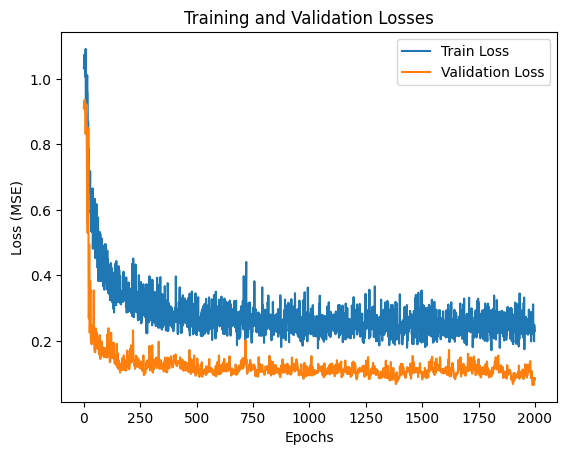

In [462]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# 1. Define the list of amino acids and initialize one-hot encoder
amino_acids = list(amino_acids_order.keys())

encoder = OneHotEncoder(sparse=False)
amino_acid_array = np.array(amino_acids).reshape(-1, 1)
one_hot_encoder = encoder.fit(amino_acid_array)

# 2. Define the function to encode amino acid and features
def encode_amino_acid_and_features(key, value, one_hot_encoder):
    """
    Encodes the amino acid part using one-hot encoding and keeps the modification data as is.

    Parameters:
    - key: The amino acid (e.g., 'V')
    - value: A tuple (pLogP_value, modification_features) from plogp_map_atoms
    - one_hot_encoder: The trained OneHotEncoder for amino acids

    Returns:
    - Combined feature vector consisting of one-hot encoded amino acid and modification features
    """
    # Extract the amino acid (key)
    amino_acid = key  # Amino acid is directly in the key (e.g., 'V')

    # Extract the modification features (value[1] is the modification data)
    modification_features = np.array(value[1])  # The list of modification features

    # One-hot encode the amino acid
    amino_acid_one_hot = one_hot_encoder.transform([[amino_acid]])  # Get the one-hot encoded vector

    # Combine the one-hot encoded amino acid and the modification features
    combined_features = np.concatenate((amino_acid_one_hot.flatten(), modification_features))

    return combined_features

# 3. Prepare the feature matrix X and target vector y from plogp_map_atoms
tokens = list(plogp_map_atoms.keys())  # List of keys (e.g., 'F[Acetyl(N-T)]')
X = np.vstack([encode_amino_acid_and_features(tok[0], plogp_map_atoms[tok], one_hot_encoder) for tok in tokens])  # shape: (n_tokens, n_features)
y = np.array([plogp_map_atoms[tok][0] for tok in tokens], dtype=float)  # Extract pLogP values (float) from the first part of the tuple

# 4. Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# 5. Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

# 6. Define a deeper MLP model with more layers and Dropout
class DeeperMLP(nn.Module):
    def __init__(self, input_dim):
        super(DeeperMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  # First hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Dropout with 30% probability

            nn.Linear(128, 64),  # Second hidden layer with 64 neurons
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Dropout again

            nn.Linear(64, 32),  # Third hidden layer with 32 neurons
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(32, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.model(x).squeeze()  # Squeeze to make output 1D

# 7. Training parameters
epochs = 2000
batch_size = 16
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 8. Initialize the model, optimizer, and loss function
model = DeeperMLP(input_dim=X_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # L2 regularization (weight decay)
criterion = nn.L1Loss()

# 9. Training loop with validation loss tracking
train_losses, valid_losses = [], []

for epoch in range(epochs):
    # Shuffle the training data
    idx = torch.randperm(X_train.size(0))
    X_train, y_train = X_train[idx], y_train[idx]

    # Mini-batch training
    model.train()
    train_loss = 0.0
    for i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Compute training loss for the epoch
    train_loss /= (len(X_train) // batch_size)
    train_losses.append(train_loss)

    # Evaluate validation loss
    model.eval()
    with torch.no_grad():
        y_pred_valid = model(X_valid.to(device)).cpu().numpy()
        valid_loss = mean_squared_error(y_valid.numpy(), y_pred_valid)
        valid_losses.append(valid_loss)

    # Print losses for this epoch
    if (epoch+1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

# 10. Final evaluation on validation set
model.eval()
with torch.no_grad():
    y_pred_valid = model(X_valid.to(device)).cpu().numpy()
    mse = mean_squared_error(y_valid.numpy(), y_pred_valid)
    r2 = r2_score(y_valid.numpy(), y_pred_valid)

print(f"\nFinal Validation MSE: {mse:.4f}")
print(f"Final Validation R²: {r2:.4f}")

# 11. Plot the training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()


In [540]:
import numpy as np
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# 1. Define the list of amino acids and initialize one-hot encoder

encoder = OneHotEncoder(sparse=False)
amino_acid_array = np.array(amino_acids).reshape(-1, 1)
one_hot_encoder = encoder.fit(amino_acid_array)

# 2. Define the function to encode amino acid and features
def encode_amino_acid_and_features(key, value, one_hot_encoder):
    """
    Encodes the amino acid part using one-hot encoding and keeps the modification data as is.

    Parameters:
    - key: The amino acid (e.g., 'V')
    - value: A tuple (pLogP_value, modification_features) from plogp_map_atoms
    - one_hot_encoder: The trained OneHotEncoder for amino acids

    Returns:
    - Combined feature vector consisting of one-hot encoded amino acid and modification features
    """
    # Extract the amino acid (key)
    amino_acid = key  # Amino acid is directly in the key (e.g., 'V')

    # Extract the modification features (value[1] is the modification data)
    modification_features = np.array(value[1])  # The list of modification features

    # One-hot encode the amino acid
    amino_acid_one_hot = one_hot_encoder.transform([[amino_acid]])  # Get the one-hot encoded vector

    # Combine the one-hot encoded amino acid and the modification features
    combined_features = np.concatenate((amino_acid_one_hot.flatten(), modification_features))

    return combined_features

# 3. Prepare the feature matrix X and target vector y from plogp_map_atoms
tokens = list(plogp_map_atoms.keys())  # List of keys (e.g., 'F[Acetyl(N-T)]')
X = np.vstack([encode_amino_acid_and_features(tok[0], plogp_map_atoms[tok], one_hot_encoder) for tok in tokens])  # shape: (n_tokens, n_features)
y = np.array([plogp_map_atoms[tok][0] for tok in tokens], dtype=float)  # Extract pLogP values (float) from the first part of the tuple

# 4. Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# 5. Initialize and train the Random Forest Regressor
svr_model = SVR(kernel='rbf', C=200, gamma=0.01, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Make predictions
y_pred_valid = svr_model.predict(X_valid)

# 7. Calculate MSE and R²
mse = mean_squared_error(y_valid, y_pred_valid)
r2 = r2_score(y_valid, y_pred_valid)

# 8. Print results
print(f"Validation MSE: {mse:.4f}")
print(f"Validation R²: {r2:.4f}")


Validation MSE: 0.1918
Validation R²: 0.8067


D:\Pycharm_envs\retention_prediction\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [528]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# 1. Define the list of amino acids and initialize one-hot encoder

encoder = OneHotEncoder(sparse=False)
amino_acid_array = np.array(amino_acids).reshape(-1, 1)
one_hot_encoder = encoder.fit(amino_acid_array)

# 2. Define the function to encode amino acid and features
def encode_amino_acid_and_features(key, value, one_hot_encoder):
    """
    Encodes the amino acid part using one-hot encoding and keeps the modification data as is.

    Parameters:
    - key: The amino acid (e.g., 'V')
    - value: A tuple (pLogP_value, modification_features) from plogp_map_atoms
    - one_hot_encoder: The trained OneHotEncoder for amino acids

    Returns:
    - Combined feature vector consisting of one-hot encoded amino acid and modification features
    """
    # Extract the amino acid (key)
    amino_acid = key  # Amino acid is directly in the key (e.g., 'V')

    # Extract the modification features (value[1] is the modification data)
    modification_features = np.array(value[1])  # The list of modification features

    # One-hot encode the amino acid
    amino_acid_one_hot = one_hot_encoder.transform([[amino_acid]])  # Get the one-hot encoded vector

    # Combine the one-hot encoded amino acid and the modification features
    combined_features = np.concatenate((amino_acid_one_hot.flatten(), modification_features))

    return combined_features
from sklearn.tree import DecisionTreeRegressor
# 3. Prepare the feature matrix X and target vector y from plogp_map_atoms
tokens = list(plogp_map_atoms.keys())  # List of keys (e.g., 'F[Acetyl(N-T)]')
X = np.vstack([encode_amino_acid_and_features(tok[0], plogp_map_atoms[tok], one_hot_encoder) for tok in tokens])  # shape: (n_tokens, n_features)
y = np.array([plogp_map_atoms[tok][0] for tok in tokens], dtype=float)  # Extract pLogP values (float) from the first part of the tuple

# 4. Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)


# Initialize Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_valid = lr_model.predict(X_valid)


# 7. Calculate MSE and R²
mse = mean_squared_error(y_valid, y_pred_valid)
r2 = r2_score(y_valid, y_pred_valid)

# 8. Print results
print(f"Validation MSE: {mse:.4f}")
print(f"Validation R²: {r2:.4f}")


Validation MSE: 0.1590
Validation R²: 0.8448


D:\Pycharm_envs\retention_prediction\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


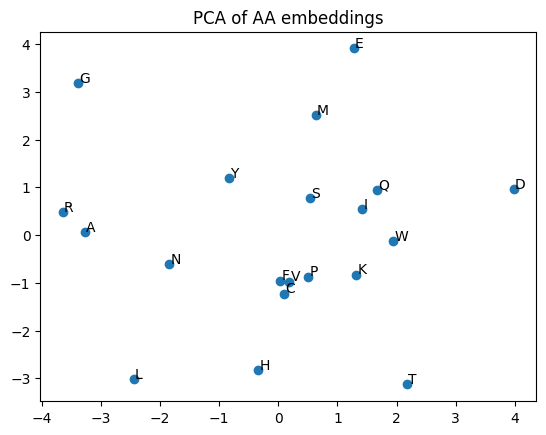

In [432]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

emb = aa_embeddings  # (20, D)
coords = PCA(n_components=2).fit_transform(emb)

plt.scatter(coords[:,0], coords[:,1])
for aa,i in amino_acids_order.items():
    plt.text(coords[i,0]+0.02, coords[i,1]+0.02, aa)
plt.title("PCA of AA embeddings"); plt.show()